# Developing an AI application

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 


The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content


First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. 

In [1]:
# Imports here
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from PIL import Image
import numpy as np

## Load the data

Here you'll use `torchvision` to load the data . The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
def load_datasets(train_dir, valid_dir, test_dir ):
    print("\nLoading Datasets")
    train_transforms= transforms.Compose([transforms.RandomRotation(30),
                                          transforms.RandomResizedCrop(224),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406],
                                                               [0.229, 0.224, 0.225])])
    validation_transforms = transforms.Compose([transforms.Resize(255),
                                                transforms.CenterCrop(224),
                                                transforms.ToTensor(),
                                                transforms.Normalize([0.485, 0.456, 0.406],
                                                               [0.229, 0.224, 0.225])])
    test_transforms= validation_transforms

    #Load the datasets with ImageFolder
    train_dataset = datasets.ImageFolder(train_dir,transform=train_transforms)
    validation_dataset= datasets.ImageFolder(valid_dir,transform= validation_transforms)
    test_dataset= datasets.ImageFolder(test_dir,transform= test_transforms)

    #Using the image datasets and the trainforms, define the dataloaders
    train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=64,shuffle=True)
    test_loader=torch.utils.data.DataLoader(test_dataset,batch_size=64,shuffle=True)
    validation_loader=torch.utils.data.DataLoader(validation_dataset,batch_size=64,shuffle=True)
    
    return train_loader, validation_loader, test_loader, train_dataset,validation_dataset

In [5]:
train_loader, validation_loader, test_loader, train_dataset, validation_dataset= load_datasets(train_dir,valid_dir,test_dir)


Loading Datasets


### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [6]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)


# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.


In [ ]:
# Build and train your network
def create_model(hidden_units, archi):
    print("\nCreating the Model")
    model_archi= {"vgg16":models.vgg16(pretrained=True)}
    
    model= model_archi[archi]
    for param in model.parameters():
        param.requires_grad = False
    
    model.classifier = nn.Sequential(nn.Linear(25088, hidden_units),
                                 nn.ReLU(),
                                 nn.Linear(hidden_units, hidden_units),
                                 nn.ReLU(),
                                 nn.Linear(hidden_units, 102),
                                 nn.LogSoftmax(dim=1))
    return model


def prepare_train(gpu, learning_rate, model):
    print("\nPreparing the Model for Training")
    device = torch.device("cuda" if torch.cuda.is_available() and gpu.lower()=="true" else "cpu")
    criterion= nn.NLLLoss()
    optimizer= optim.Adam(model.classifier.parameters(),lr= float(learning_rate))
    model.to(device)
    return model, device, criterion, optimizer

def train_model(model,epochs,train_loader,validation_loader,device,criterion, optimizer):
    print("\nTraining the Model")
    for epoch in range(epochs):
        epoch_loss=0
        train_accuracy=0
        for images,labels in train_loader:
            images, labels= images.to(device), labels.to(device)
            logps= model(images)
            loss= criterion(logps,labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss+=loss.item()
            ps=torch.exp(logps)
            _,top_class= ps.topk(1,dim=1)
            equals= top_class==labels.view(*top_class.shape)
            train_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

        else:
            valid_loss=0
            valid_accuracy=0
            model.eval()
            with torch.no_grad():
                for images,labels in validation_loader:
                    images,labels = images.to(device),labels.to(device)
                    logps= model(images)
                    loss= criterion(logps,labels)
                    valid_loss+= loss.item()

                    ps=torch.exp(logps)
                    _,top_class= ps.topk(1,dim=1)
                    equals= top_class==labels.view(*top_class.shape)
                    valid_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()


            print(f"Epoch {epoch+1}/{epochs}.. "
                      f"Train loss: {epoch_loss/len(train_loader):.3f}.. "
                      f"Validation loss: {valid_loss/len(validation_loader):.3f}.. "
                      f"Training accuracy: {train_accuracy/len(train_loader):.3f}.."
                      f"Validation accuracy: {valid_accuracy/len(validation_loader):.3f}")
            model.train()
            
            
    return model

In [ ]:
model= create_model(4096, 'vgg16')
print(model)
model, device, criterion, optimizer= prepare_train( 'true', '0.0001', model)


In [135]:
model= train_model(model, 5, train_loader, validation_loader, device, criterion, optimizer)


Training the Model
Epoch 1/5.. Train loss: 0.506.. Validation loss: 0.336.. Training accuracy: 0.859..Validation accuracy: 0.907
Epoch 2/5.. Train loss: 0.463.. Validation loss: 0.321.. Training accuracy: 0.869..Validation accuracy: 0.920
Epoch 3/5.. Train loss: 0.435.. Validation loss: 0.342.. Training accuracy: 0.878..Validation accuracy: 0.916
Epoch 4/5.. Train loss: 0.394.. Validation loss: 0.325.. Training accuracy: 0.893..Validation accuracy: 0.926
Epoch 5/5.. Train loss: 0.402.. Validation loss: 0.322.. Training accuracy: 0.885..Validation accuracy: 0.920


## Testing your network


In [5]:
def test_model(model, device, criterion, test_loader):
    print("\nTesting the Model")
    test_loss=0
    accuracy=0
    model.to(device)
    model.eval()
    with torch.no_grad():
        for images,labels in test_loader:
            images,labels = images.to(device),labels.to(device)
            logps= model(images)
            loss= criterion(logps,labels)
            test_loss+= loss.item()

            ps=torch.exp(logps)
            _,top_class= ps.topk(1,dim=1)
            equals= top_class==labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

    print(f"\nTest loss: {test_loss/len(test_loader):.3f}.. Test accuracy: {accuracy/len(test_loader):.3f}")

In [136]:
test_model(model, device, criterion, test_loader)


Testing the Model

Test loss: 0.278.. Test accuracy: 0.921


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [137]:
def save_model(model, checkpoint_path, archi):
    checkpoint = {'input_size': model.classifier[0].in_features,
                  'output_size': 102,
                  'archi': archi,
                  'training_epochs': 10,
                  'class_to_idx':train_dataset.class_to_idx,
                  'hidden_layers': [ each.out_features for each in model.classifier if type(each)==torch.nn.modules.linear.Linear],
                  'state_dict': model.state_dict()}

    torch.save(checkpoint, checkpoint_path)
    print("\nModel Saved Successfully")

In [138]:
save_model(model,'checkpoint1.pth','vgg16')


Model Saved Successfully


## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [31]:
def load_checkpoint(filepath):
    map_location= "cuda" if torch.cuda.is_available() else "cpu"
    checkpoint = torch.load(filepath, map_location= map_location)
    archi={'vgg16':models.vgg16(pretrained=True)}
    model= archi[checkpoint['archi']]
    hidden_layers= checkpoint['hidden_layers']
    classifier= nn.ModuleList([nn.Linear(checkpoint['input_size'], hidden_layers[0]), nn.ReLU()])
    layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:-1])
    for h1, h2 in layer_sizes:
        classifier.extend([nn.Linear(h1, h2),nn.ReLU()])
    classifier.extend([nn.Linear(hidden_layers[-2], checkpoint['output_size']),nn.LogSoftmax(dim=1)])
    model.classifier= nn.Sequential(*classifier)
    model.load_state_dict(checkpoint['state_dict'])
    model.epochs= checkpoint['training_epochs']
    model.class_to_idx= checkpoint['class_to_idx']
    print("\nModel Loaded Successfully")
    return model

In [32]:
model = load_checkpoint('checkpoint1.pth')


Model Loaded Successfully


# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [33]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model
    image= image.resize((256,256))
    crop= transforms.CenterCrop(224)
    image=crop(image)
    image=np.array(image)/255
    mean=np.array([0.485, 0.456, 0.406])
    std=np.array([0.229, 0.224, 0.225])
    image= (image-mean)/std
    image=image.transpose((2, 0, 1))
    return image

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [34]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    #image = image.numpy().transpose((1, 2, 0))
    image = np.array(image).transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

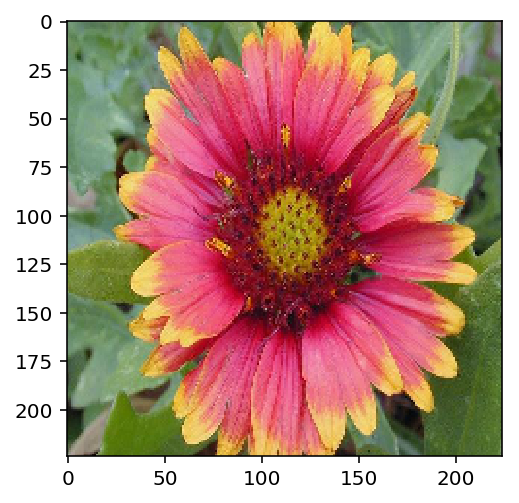

In [35]:
image = Image.open("flowers/test/100/image_07897.jpg")
imshow(process_image(image))

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [36]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    image = Image.open(image_path)
    image= process_image(image)
    image= np.expand_dims(image, axis=0)
    image= torch.from_numpy(image).float()
    model.to(device)
    image= image.to(device)
    model.eval()
    with torch.no_grad():
        logps= model(image)
    ps=torch.exp(logps)
    top_p,top_class= ps.topk(topk,dim=1)
    keys= list(model.class_to_idx.keys())
    values= list(model.class_to_idx.values())
    t_class=[]
    for i in top_class[0].cpu().numpy():
        t_class.append(int(keys[values.index(i)]))
    return top_p,t_class

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:


You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

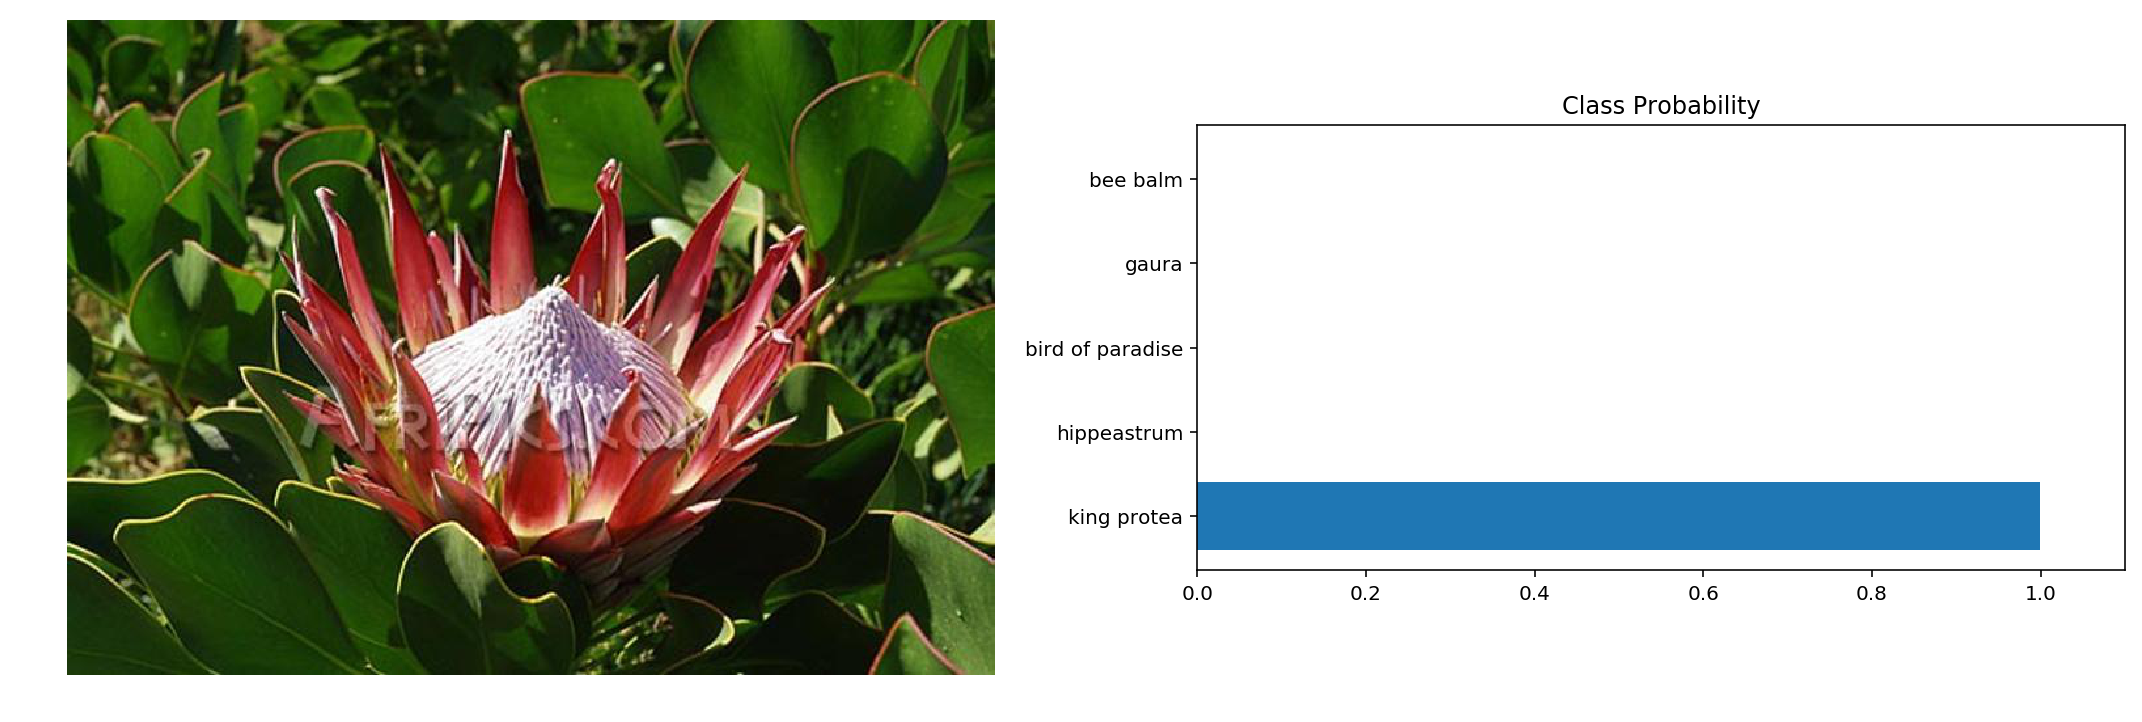

In [37]:
# TODO: Display an image along with the top 5 classes
import json
image_path= "flowers/test/13/image_05775.jpg"
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
top_p, top_class= predict(image_path, model)
y=[]
image = Image.open(image_path)
for i in top_class:
    y.append(cat_to_name[str(i)])
fig, (ax1, ax2) = plt.subplots(figsize=(15,20), ncols=2)
ax1.imshow(image)
ax1.axis('off')
top_p = top_p.cpu().data.numpy().squeeze()
ax2.barh(np.arange(5), top_p)
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(5))
ax2.set_yticklabels(y)
ax2.set_title('Class Probability')
ax2.set_xlim(0, 1.1)
plt.tight_layout()

In [29]:
cat_to_name["13"]

'king protea'

In [30]:
top_class[0]

13